# AI6126 ACV Project 1


## Changelogs

+ V0.1 - Setup codes to download and unzip celeba to gDrive
+ V0.2 - Added training loop 



## References:
+ [PyTorch Transfer Learning](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html)
+ [TWD fast.ai](https://towardsdatascience.com/real-time-multi-facial-attribute-detection-using-transfer-learning-and-haar-cascades-with-fastai-47ff59e36df0)

In [1]:
nb_ver = 0.2

## Setup/ Configuration

In [2]:
# you can choose to mount your Google Drive (optional)
import sys, os
if 'google.colab' in sys.modules:
    from google.colab import drive
    drive.mount('/content/drive')
    file_name = f'ai6126-project1-colab-v{nb_ver}.ipynb'
    print(file_name)
    import subprocess
    path_to_file = subprocess.check_output('find . -type f -name ' + str(file_name), shell=True).decode("utf-8")
    print(path_to_file)
    path_to_file = path_to_file.replace(file_name,"").replace('\n',"")
    os.chdir(path_to_file)
    !pwd
    

In [3]:
# check nvcc version
!nvcc -V
# check GCC version
!gcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Wed_Oct_23_19:32:27_Pacific_Daylight_Time_2019
Cuda compilation tools, release 10.2, V10.2.89


'gcc' is not recognized as an internal or external command,
operable program or batch file.


In [4]:
# set the backend of matplotlib to the 'inline' backend
%matplotlib inline

In [5]:
import os
import time
import glob
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import numpy as np
import copy
import config
from celeba_dataset import CelebaDataset

plt.ion() 

In [6]:
# check PyTorch version and cuda status
print(torch.__version__, torch.cuda.is_available())

# set random seed for reproducibility
manualSeed = 42
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

1.6.0 True
Random Seed:  42


In [7]:
local_download_path = '../data/celeba/img_align_celeba'
download_dataset = True
if os.path.exists(local_download_path):
    images = glob.glob(local_download_path + '/*.jpg')
    if len(images) == 202599:
        download_dataset = False
print(f"download celeba dataset: {download_dataset}")

download celeba dataset: False


In [8]:
if download_dataset:
    # create dataset root and enter it
    !mkdir -p data/celeba
    %cd data/celeba

    # we have prepared a backup of `img_align_celeba.zip` of Celeb-A dataset in the Dropbox
    # download it directly, or manually download the original file from Google Drive above
    !wget https://www.dropbox.com/s/8kzo40fqx7nodat/img_align_celeba.zip

    # unzip the downloaded file
    !unzip -qq img_align_celeba.zip
    !rm -f img_align_celeba.zip

    # change the directory back to the root
    %cd ../..
    !ls

In [9]:
dataroot = '../data/celeba/img_align_celeba/'
image_size = 64
batch_size = 128
dl_workers = 8

In [10]:
# # we can use an image folder dataset the way we have it setup.
# # create the dataset
# dataset = dset.ImageFolder(root=dataroot,
#                            transform=transforms.Compose([
#                                transforms.Resize(image_size),
#                                transforms.CenterCrop(image_size),
#                                transforms.ToTensor(),
#                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
#                            ]))
# # create the dataloader
# dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
#                                          shuffle=True, num_workers=workers)

# # decide which device we want to run on
# device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# # plot some training images
# real_batch = next(iter(dataloader))
# plt.figure(figsize=(8,8))
# plt.axis("off")
# plt.title("Training Images")
# plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [11]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
#         transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
#         transforms.Resize(256),
#         transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

attributes_list = {
    'train': config.TRAIN_ATTRIBUTE_LIST,
    'val': config.VAL_ATTRIBUTE_LIST
}

image_datasets = {x: CelebaDataset(config.IMG_DIR, attributes_list[x], data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size,
                                             shuffle=True, num_workers=dl_workers)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].targets

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [12]:
print(len(class_names[0]))
print(dataset_sizes)

40
{'train': 162770, 'val': 19867}


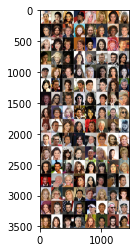

In [13]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=None)

In [14]:
def accuracy(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        for k in topk:
            correct_k = correct[:k].view(-1).float().sum(0)
            res.append(correct_k.mul_(100.0 / batch_size))
        return res

In [ ]:
class AverageMeter(object):
    """Computes and stores the average and current value
       Imported from https://github.com/pytorch/examples/blob/master/imagenet/main.py#L247-L262
    """
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            losses = [AverageMeter() for _ in range(40)]
            top1 = [AverageMeter() for _ in range(40)]

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # measure accuracy and record loss
                    loss = []
                    prec1 = []
                    outputs = model(inputs)
                    for j in range(len(outputs)):
                        loss.append(criterion(outputs[j], labels[:, j]))
                        prec1.append(accuracy(outputs[j], labels[:, j], topk=(1,)))

                        losses[j].update(loss[j].detach().item(), inputs.size(0))
                        top1[j].update(prec1[j][0].item(), inputs.size(0))
                    losses_avg = [losses[k].avg for k in range(len(losses))]
                    top1_avg = [top1[k].avg for k in range(len(top1))]
                    loss_avg = sum(losses_avg) / len(losses_avg)
                    prec1_avg = sum(top1_avg) / len(top1_avg)
                    #_, preds = torch.max(outputs, 1)
                    #loss = criterion(outputs, labels)
                    loss_sum = sum(loss)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        #loss.backward()
                        loss_sum.backward()
                        optimizer.step()

                # statistics
                #running_loss += loss.item() * inputs.size(0)
                #running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            #epoch_loss = running_loss / dataset_sizes[phase]
            #epoch_acc = running_corrects.double() / dataset_sizes[phase]
            epoch_loss = loss_avg
            epoch_acc = prec1_avg
            print('{} Loss: {:.4f} Prec1: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
# def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
#     since = time.time()

#     best_model_wts = copy.deepcopy(model.state_dict())
#     best_acc = 0.0

#     for epoch in range(num_epochs):
#         print('Epoch {}/{}'.format(epoch, num_epochs - 1))
#         print('-' * 10)

#         # Each epoch has a training and validation phase
#         for phase in ['train', 'val']:
#             if phase == 'train':
#                 model.train()  # Set model to training mode
#             else:
#                 model.eval()   # Set model to evaluate mode

#             running_loss = 0.0
#             losses = [AverageMeter() for _ in range(40)]
#             top1 = [AverageMeter() for _ in range(40)]

#             # Iterate over data.
#             for inputs, labels in dataloaders[phase]:
#                 inputs = inputs.to(device)
#                 labels = labels.to(device)

#                 # zero the parameter gradients
#                 optimizer.zero_grad()

#                 # forward
#                 # track history if only in train
#                 with torch.set_grad_enabled(phase == 'train'):
#                     # measure accuracy and record loss
#                     loss = []
#                     prec1 = []
#                     outputs = model(inputs)
#                     for j in range(len(outputs)):
#                         loss.append(criterion(outputs[j], labels[:, j]))
#                         prec1.append(accuracy(outputs[j], labels[:, j], topk=(1,)))

#                         losses[j].update(loss[j].detach().item(), inputs.size(0))
#                         top1[j].update(prec1[j][0].item(), inputs.size(0))
#                     losses_avg = [losses[k].avg for k in range(len(losses))]
#                     top1_avg = [top1[k].avg for k in range(len(top1))]
#                     loss_avg = sum(losses_avg) / len(losses_avg)
#                     prec1_avg = sum(top1_avg) / len(top1_avg)
#                     #_, preds = torch.max(outputs, 1)
#                     #loss = criterion(outputs, labels)
#                     loss_sum = sum(loss)

#                     # backward + optimize only if in training phase
#                     if phase == 'train':
#                         #loss.backward()
#                         loss_sum.backward()
#                         optimizer.step()

#                 # statistics
#                 #running_loss += loss.item() * inputs.size(0)
#                 #running_corrects += torch.sum(preds == labels.data)
#             if phase == 'train':
#                 scheduler.step()

#             #epoch_loss = running_loss / dataset_sizes[phase]
#             #epoch_acc = running_corrects.double() / dataset_sizes[phase]
#             epoch_loss = loss_avg
#             epoch_acc = prec1_avg
#             print('{} Loss: {:.4f} Prec1: {:.4f}'.format(
#                 phase, epoch_loss, epoch_acc))

#             # deep copy the model
#             if phase == 'val' and epoch_acc > best_acc:
#                 best_acc = epoch_acc
#                 best_model_wts = copy.deepcopy(model.state_dict())

#         print()

#     time_elapsed = time.time() - since
#     print('Training complete in {:.0f}m {:.0f}s'.format(
#         time_elapsed // 60, time_elapsed % 60))
#     print('Best val Acc: {:4f}'.format(best_acc))

#     # load best model weights
#     model.load_state_dict(best_model_wts)
#     return model

In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [ ]:
model_ft = models.resnet18(pretrained=True)
print(model_ft)


In [ ]:
class fc_block(nn.Module):
    def __init__(self, inplanes, planes, drop_rate=0.15):
        super(fc_block, self).__init__()
        self.fc = nn.Linear(inplanes, planes)
        self.bn = nn.BatchNorm1d(planes)
        if drop_rate > 0:
            self.dropout = nn.Dropout(drop_rate)
        self.relu = nn.ReLU(inplace=True)
        self.drop_rate = drop_rate

    def forward(self, x):
        x = self.fc(x)
        x = self.bn(x)
        if self.drop_rate > 0:
            x = self.dropout(x)
        x = self.relu(x)
        return x

class My_CNN_Model(nn.Module):
    def __init__(self, pt_model, num_attributes=40):
        super(My_CNN_Model, self).__init__()
        num_ftrs = pt_model.fc.out_features
#         print(num_ftrs)
        self.pretrained = pt_model
        self.num_attributes = num_attributes
        for i in range(num_attributes):
            setattr(self, 'classifier' + str(i).zfill(2), 
                    nn.Sequential(fc_block(num_ftrs, num_ftrs//2), 
                                  nn.Linear(num_ftrs//2, 2)))
        
            
    def forward(self, x):
        x = self.pretrained(x)
#         print(x.shape)    
        y = []
        for i in range(self.num_attributes):
            classifier = getattr(self, 'classifier' + str(i).zfill(2))
            y.append(classifier(x))
        return y

In [ ]:
my_cnn = My_CNN_Model(model_ft)

In [ ]:
my_cnn = my_cnn.to(device)
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
my_cnn = train_model(my_cnn, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)